In [70]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from data.dataset import MetaDataset
from env import sr, frame_size
from loss import MSE, MelMSE, MelMeanFilteredMSE, MelGaussianFilteredMSE
from data.metadata.vcc import (
    SanityMetadata, VCC2016TrainMetadata,
    VCC2016TrainAppendedMetadata)
from models import save_model, load_model
from models.vae import ToyVAE, MultiFeaturePerceptron, CustomModel
from maml import reptile_train
from data import read_audio, AudioData
from data.transform import log_stft, db_to_amp
from data.dataset import (
    TaskDataset, InputData,
    from_gen_model_output, to_gen_model_output)
from visualization import plot_spec
from vocoder import griffin_lim
from utils import get_model_param_count

plt.style.use({'figure.facecolor':'white'})

In [72]:
# meta_data = SanityMetadata()
# meta_data = VCC2016TrainMetadata()
meta_data = VCC2016TrainAppendedMetadata()

In [73]:
dataset = MetaDataset(meta_data)
dataset.read_and_preprocess()
print('Data loaded', datetime.now())

Data loaded 2021-11-30 21:13:36.214947


In [74]:
ModelClass = CustomModel
print(ModelClass())

CustomModel(
  (formant_encoder): Sequential(
    (0): Conv1d(1, 3, kernel_size=(16,), stride=(2,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv1d(3, 5, kernel_size=(8,), stride=(4,))
    (3): LeakyReLU(negative_slope=0.01)
  )
  (formant_transform): Sequential(
    (0): Linear(in_features=752, out_features=615, bias=True)
  )
  (formant_decoder): Sequential(
    (0): ConvTranspose1d(5, 3, kernel_size=(8,), stride=(2,), output_padding=(1,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose1d(3, 1, kernel_size=(16,), stride=(4,), output_padding=(1,))
  )
  (fundamental_freq_model): Sequential(
    (0): Linear(in_features=212, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=16, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=16, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=128, out_features=1025, bias=True)
  )
)


In [75]:
device = torch.device('cuda')
model = ModelClass().to(device)

# criterion = MSE()
criterion = nn.MSELoss()
# criterion = nn.L1Loss()
# criterion = MelMSE(is_input_log_amp=True, n_mel=512)
# criterion = MelMeanFilteredMSE(max_filter_size=10)
# criterion = MelGaussianFilteredMSE(max_filter_size=8)
if isinstance(criterion, nn.Module):
    criterion = criterion.to(device)


class OptimizerMgr:
    def __init__(self):
        self.instance = None
    def create_instance(self, model):
        # self.instance = optim.SGD(model.parameters(),
        #                           lr=1e-3, weight_decay=0) # 2e-4
        # self.instance = optim.Adam(model.parameters(),
        #                            lr=1e-5, weight_decay=0)
        self.instance = optim.Adam(model.parameters(),
                                   lr=1e-3, weight_decay=0)

    def get(self):
        return self.instance


optimizer_mgr = OptimizerMgr()

def train(model, x, y,
          n_iter=1000, log_period=None, test_proportion=0):
    # optimizer_mgr.create_instance(model)
    optimizer = optimizer_mgr.get()
    model.train()
    x = x.transpose(0, 1)
    # y = y.transpose(0, 1)
    x = x.to(device)
    y = y.to(device)
    if test_proportion is None or test_proportion == 0:
        train_x, train_y = x, y
    else:
        test_indices = np.random.choice(x.shape[0],
                                        int(x.shape[0] * test_proportion))
        mask = np.zeros(x.shape[0], dtype=bool)
        mask[test_indices] = True
        test_x, test_y = x[mask], y[:, mask]
        train_x, train_y = x[~mask], y[:, ~mask]
    for i in range(n_iter):
        optimizer.zero_grad()
        out = model(train_x)
        out = out.transpose(0, 1)
        loss = criterion(out[:, :], train_y[:, :])
        loss.backward()
        optimizer.step()
        if log_period is not None and i % log_period == 0:
            print('Pass', i, ': ', loss.item(), end='')
            if test_proportion is not None and test_proportion != 0:
                with torch.no_grad():
                    out = model(test_x)
                    out = out.transpose(0, 1)
                    loss = criterion(out[:, :], test_y[:, :])
                    print('; Test', i, ': ', loss.item(), end='')
            print()


def sound(x, rate=sr, label=''):
    from IPython.display import display, Audio, HTML
    display(HTML(
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>'
        + label + '</td><td>' + Audio(x, rate=rate)._repr_html_()[3:]
        + '</td></tr></table>'
    ))

Pass 0 :  0.5460103154182434; Test 0 :  0.49610936641693115
Pass 200 :  0.01772867701947689; Test 200 :  0.020215213298797607
Pass 400 :  0.010930154472589493; Test 400 :  0.016084661707282066
Pass 600 :  0.007496519945561886; Test 600 :  0.014965361915528774
Pass 800 :  0.005477338097989559; Test 800 :  0.013731866143643856
Pass 1000 :  0.004239528905600309; Test 1000 :  0.012618948705494404
Pass 1200 :  0.0033254087902605534; Test 1200 :  0.012499960139393806
Pass 1400 :  0.0027734197210520506; Test 1400 :  0.01167747937142849
Pass 1600 :  0.0036864520516246557; Test 1600 :  0.01143690012395382
Pass 1800 :  0.0021284748800098896; Test 1800 :  0.011521589942276478
Pass 2000 :  0.0019132636953145266; Test 2000 :  0.011120470240712166
Pass 2200 :  0.0016603863332420588; Test 2200 :  0.01110923197120428
Pass 2400 :  0.001563071389682591; Test 2400 :  0.010889771394431591
Pass 2600 :  0.0013882482890039682; Test 2600 :  0.010852506384253502
Pass 2800 :  0.0012519541196525097; Test 2800 : 

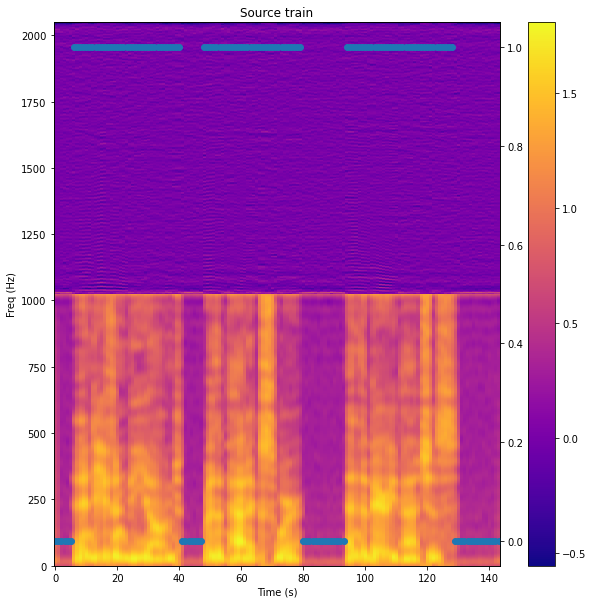

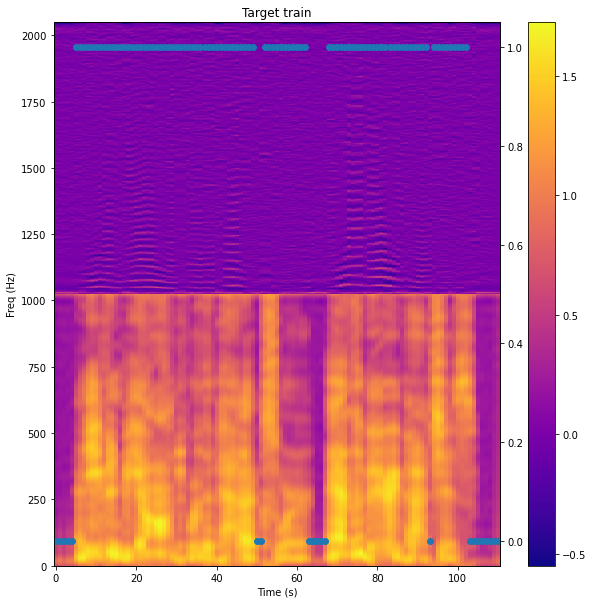

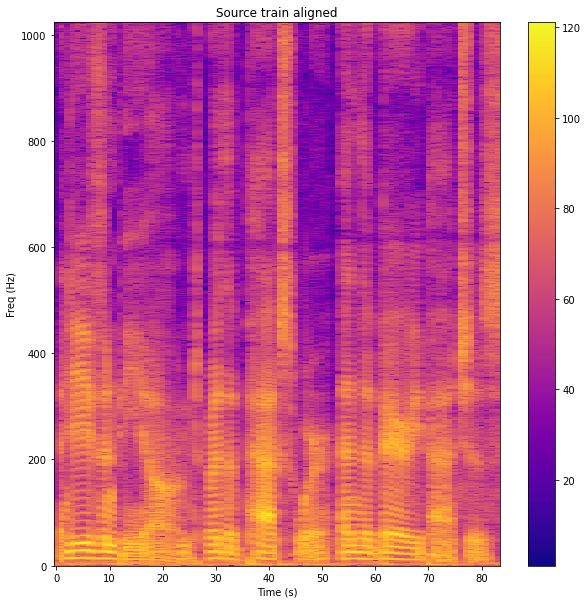

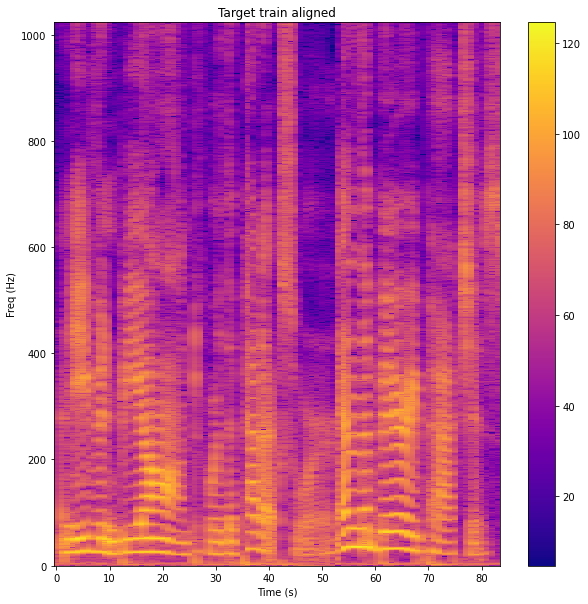

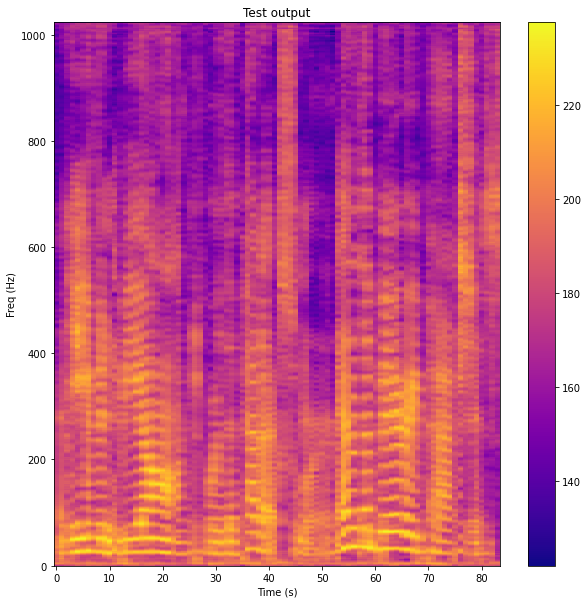

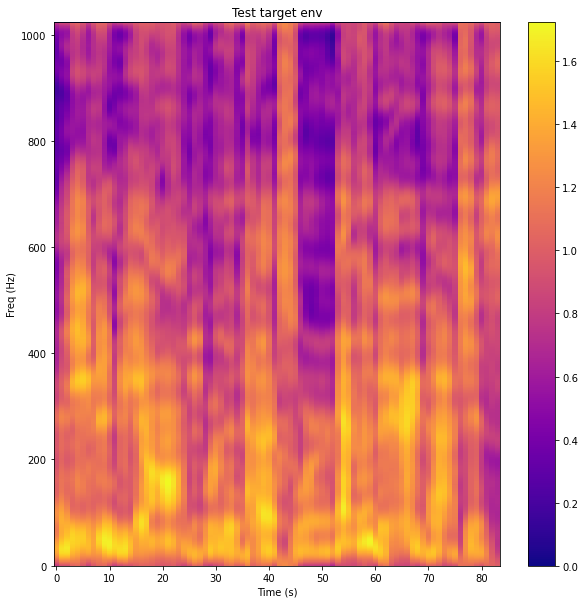

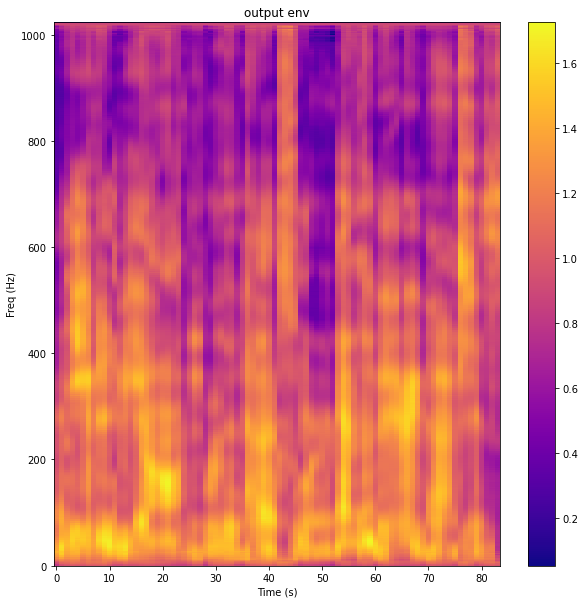

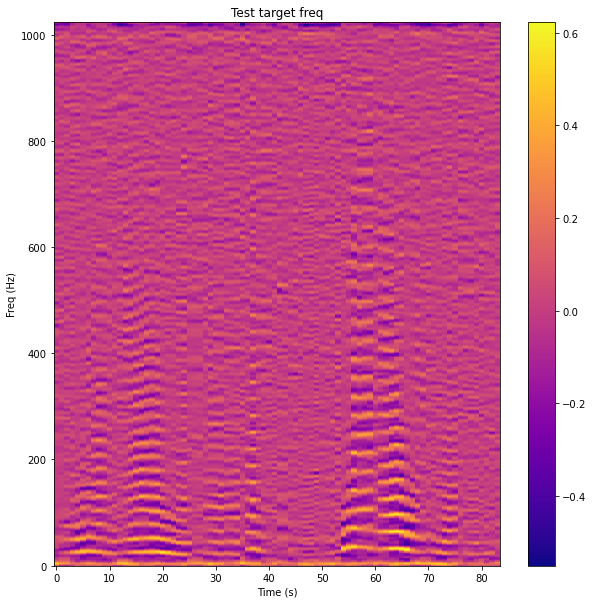

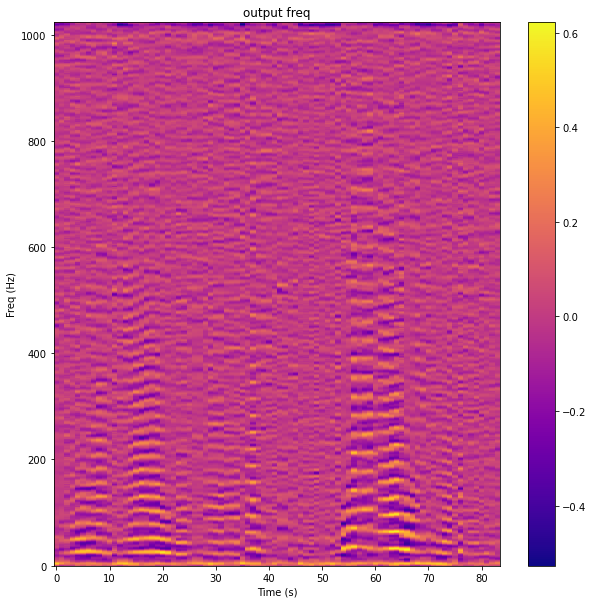

In [76]:
"""
This code block tests whether a model is "learnable" for a certain task
It simply fixes a single task and trains the model, and then it checks
model performance w.r.t. train set.
"""

def learnable_test(model, train_source_filename, train_target_filename,
                   vocode=True):
    from data.dataset import to_gen_model_output
    def plot_selected_frames(selected_frames):
        plt.twinx()
        plt.scatter(np.arange(selected_frames.size), selected_frames)

    task_dat = TaskDataset(train_source_filename, train_target_filename)
    # plot raw spec
    plot_spec(to_gen_model_output(task_dat.source.amp), title='Source train',
              figure_size=(10,10))
    plot_selected_frames(task_dat.source.selected_frames)
    plot_spec(to_gen_model_output(task_dat.target.amp), title='Target train',
              figure_size=(10,10))
    plot_selected_frames(task_dat.target.selected_frames)
    # plot aligned spec
    amp_x_aligned, amp_y_aligned = task_dat.get_as_aligned_amp()
    plot_spec(log_stft(amp_x_aligned), title='Source train aligned',
              figure_size=(10,10))
    plot_spec(log_stft(amp_y_aligned), title='Target train aligned',
          figure_size=(10,10))
    if vocode:
        sound(griffin_lim(amp_x_aligned), label='Source train aligned')
        sound(griffin_lim(amp_y_aligned), label='Target train aligned')
    # train
    train_x, train_y = task_dat.get()
    optimizer_mgr.create_instance(model)
    train(model,
          torch.from_numpy(train_x.astype(np.float32)),
          torch.from_numpy(train_y.astype(np.float32)),
          n_iter=5000, log_period=200, test_proportion=0.2) # TODO: tune this
    # test with train dataset
    estimated = model(torch.from_numpy(train_x).transpose(0, 1).to(device))
    raw_estimated = estimated.detach().cpu().numpy().T
    y = from_gen_model_output(estimated).detach().cpu().numpy().T
    # if isinstance(criterion, MelMSE):
    #     mel_y = criterion.mel(estimated.T).detach().cpu().numpy()
    #     mel_target = criterion.mel(
    #         torch.from_numpy(train_y.astype(np.float32)).to(device)
    #     ).detach().cpu().numpy()
    #     plot_spec(mel_y, title='mel y',figure_size=(10,10))
    #     plot_spec(mel_target, title='mel target',figure_size=(10,10))
    plot_spec(log_stft(y), title='Test output',figure_size=(10,10))
    plot_spec(train_y[:frame_size], title='Test target env',
              figure_size=(10,10))
    plot_spec(raw_estimated[:frame_size], title='output env',
              figure_size=(10,10))
    plot_spec(train_y[frame_size:], title='Test target freq',
              figure_size=(10,10))
    plot_spec(raw_estimated[frame_size:], title='output freq',
              figure_size=(10,10))
    if vocode:
        sound(griffin_lim(y), label='Test estimate')

learnable_test(model, meta_data.get(3, 0), meta_data.get(0, 0))


In [77]:
# Meta train

model = ModelClass().to(device)
optimizer_mgr.create_instance(model)

reptile_train(model, dataset, n_shot=None,
              n_iter_meta=1000, meta_step_size=5e-2,
              inner_train_func=train, n_iter_inner=10,
              log_period_meta=50, log_period_inner=2)

save_model('saved_models/' + type(model).__name__ + '.pt', model)

Meta iter 0 : 
Pass 0 :  0.792073130607605
Pass 2 :  0.7808953523635864
Pass 4 :  0.7697433829307556
Pass 6 :  0.7632119655609131
Pass 8 :  0.7579954266548157
Meta iter 50 : 
Pass 0 :  0.6940118074417114
Pass 2 :  0.6914015412330627
Pass 4 :  0.6887510418891907
Pass 6 :  0.6860562562942505
Pass 8 :  0.6832776665687561
Meta iter 100 : 
Pass 0 :  0.5394673347473145
Pass 2 :  0.48793601989746094
Pass 4 :  0.4297758638858795
Pass 6 :  0.36592158675193787
Pass 8 :  0.29965367913246155
Meta iter 150 : 
Pass 0 :  0.14888305962085724
Pass 2 :  0.13729801774024963
Pass 4 :  0.12627051770687103
Pass 6 :  0.11654599756002426
Pass 8 :  0.10824798792600632
Meta iter 200 : 
Pass 0 :  0.07570082694292068
Pass 2 :  0.07043947279453278
Pass 4 :  0.06518999487161636
Pass 6 :  0.06050235033035278
Pass 8 :  0.05650351569056511
Meta iter 250 : 
Pass 0 :  0.041609447449445724
Pass 2 :  0.03981594741344452
Pass 4 :  0.037867020815610886
Pass 6 :  0.03596147522330284
Pass 8 :  0.03422517701983452
Meta iter 30

In [78]:
print(type(model).__name__, ', number of params:', get_model_param_count(model))

CustomModel , number of params: 627172


In [79]:
# Second train after meta training

pretrained_model = load_model('saved_models/' + type(model).__name__ + '.pt',
                              ModelClass).to(device)


Pass 0 :  0.029159635305404663
Pass 100 :  0.017215169966220856
Pass 200 :  0.012789790518581867
Pass 300 :  0.010400557890534401
Pass 400 :  0.008768755942583084
Pass 500 :  0.007466016802936792
Pass 600 :  0.0066594635136425495
Pass 700 :  0.006130835507065058
Pass 800 :  0.005933256354182959
Pass 900 :  0.005883669480681419
torch.Size([84, 2050])


torch.Size([84, 2050])
(1025, 84)


torch.Size([156, 2050])


torch.Size([156, 2050])
(1025, 156)


torch.Size([238, 2050])


torch.Size([231, 2050])
(1025, 231)


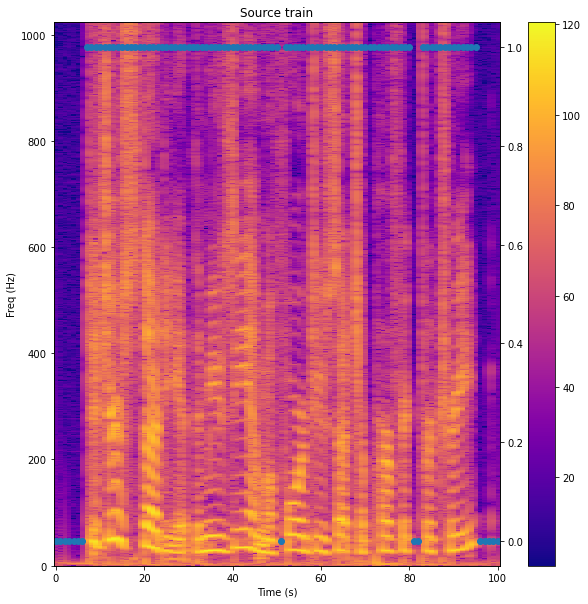

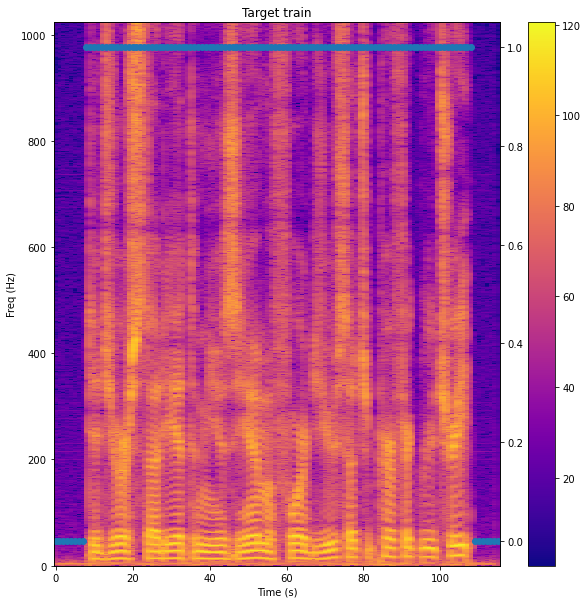

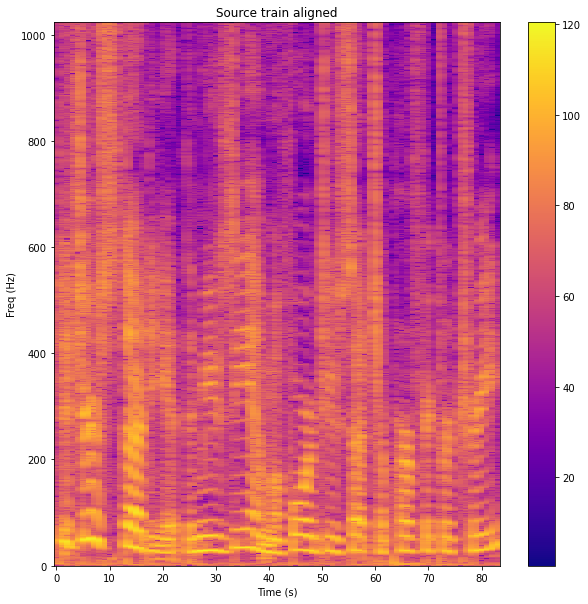

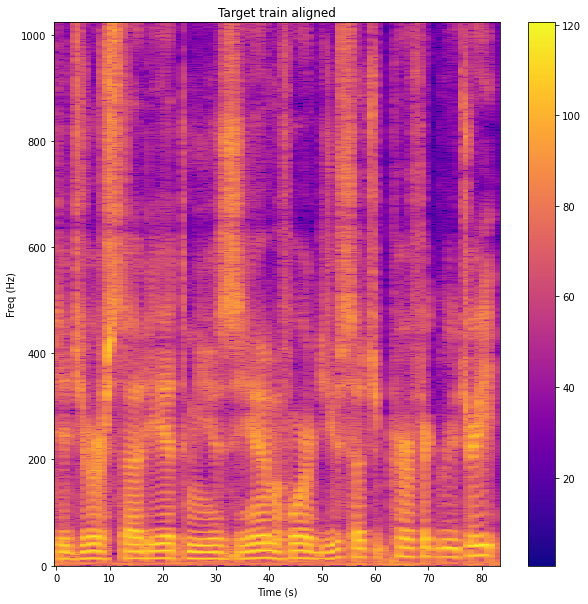

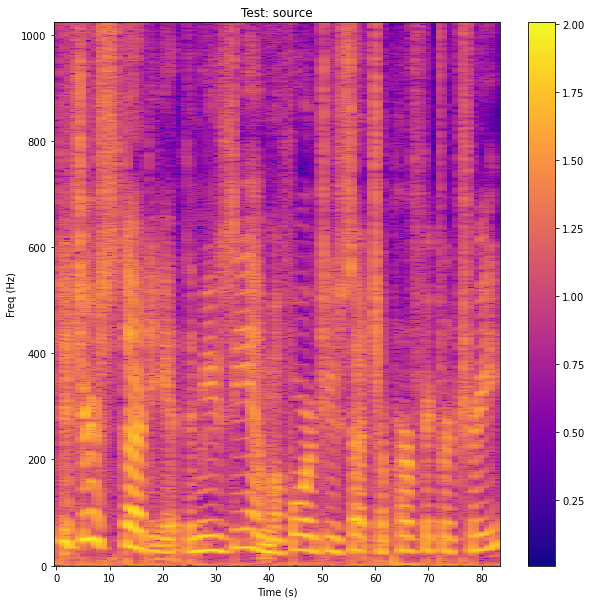

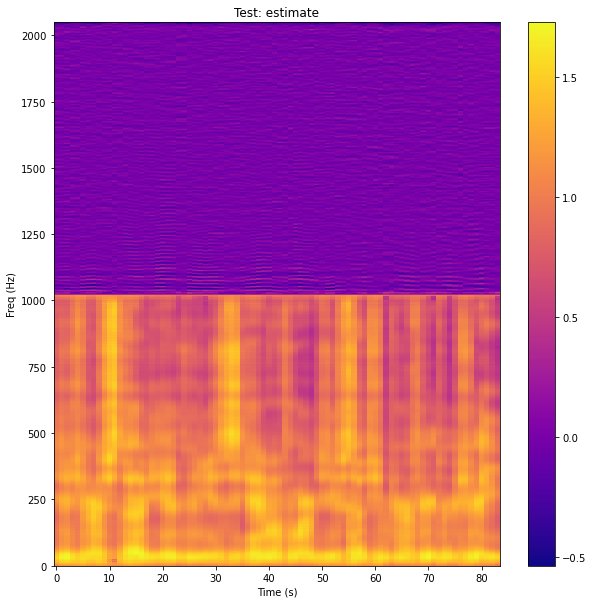

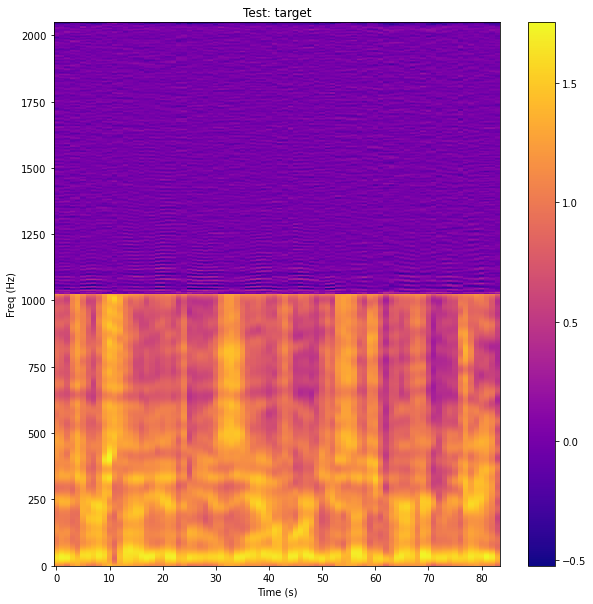

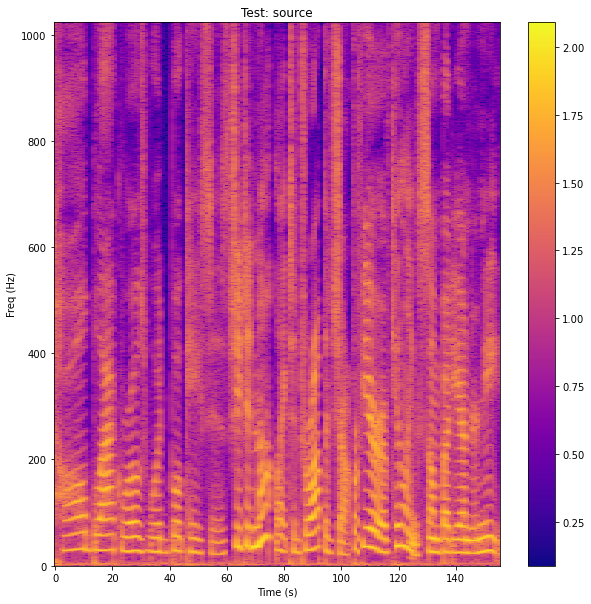

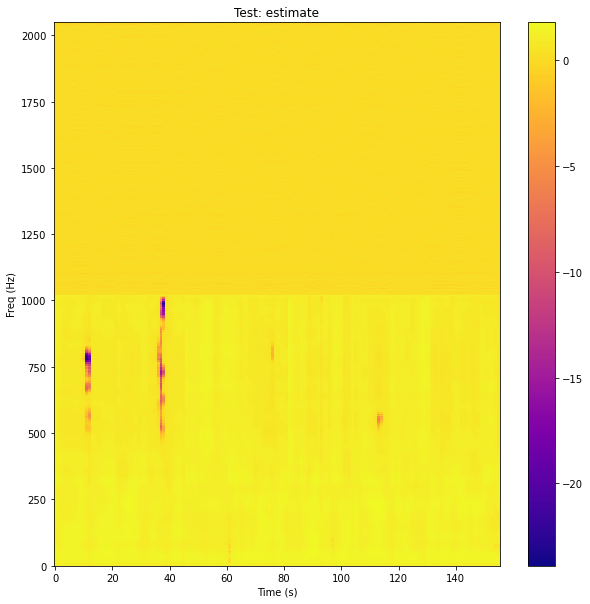

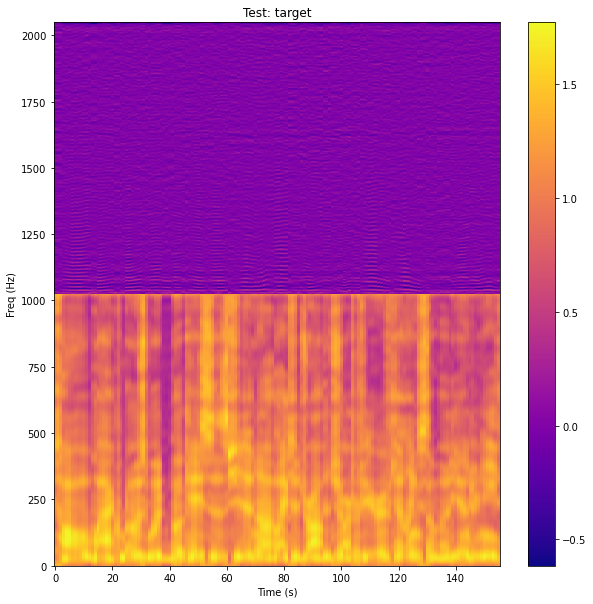

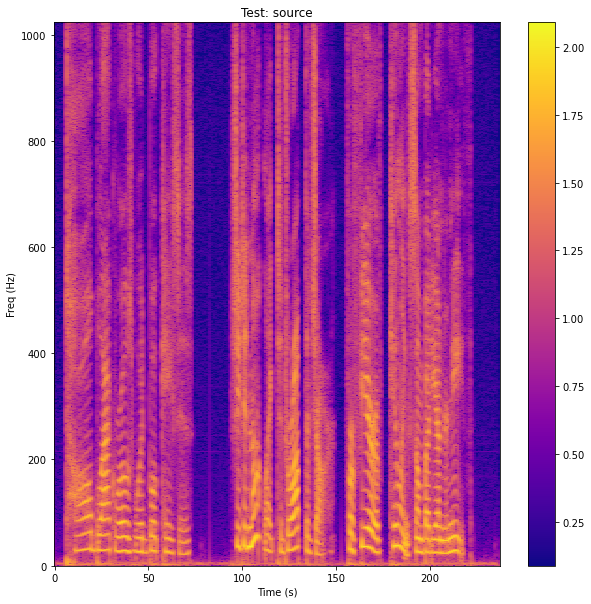

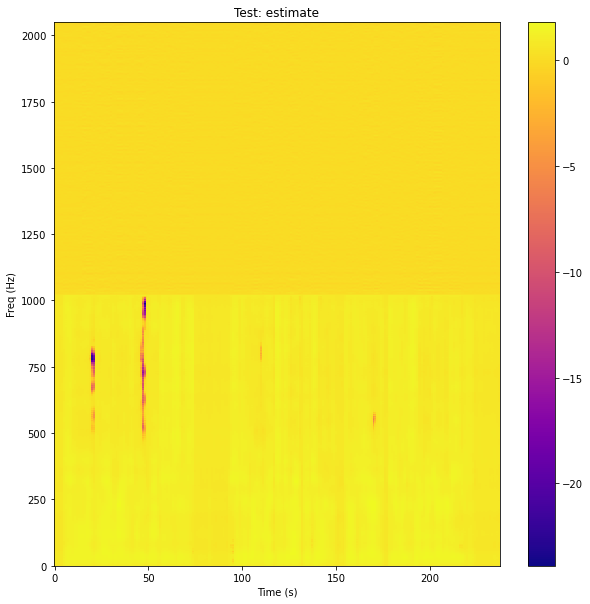

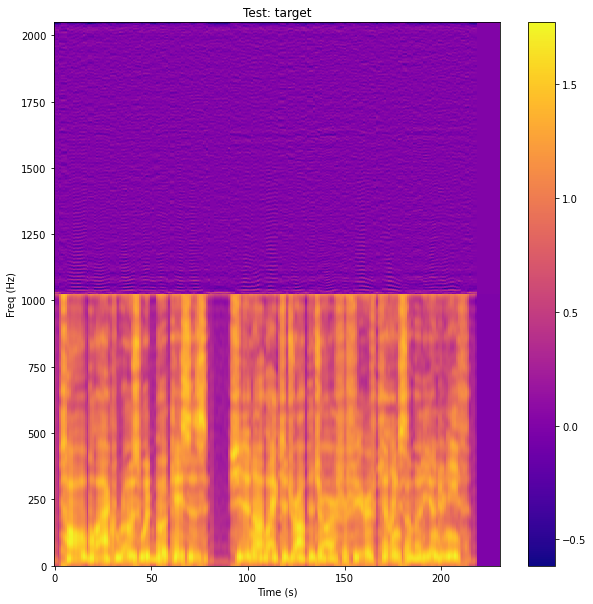

In [80]:


def test(task_model,
         train_source_filename, train_target_filename,
         test_input_filename, test_target_filename,
         second_train=False, vocode=True):
    def plot_selected_frames(selected_frames):
        plt.twinx()
        plt.scatter(np.arange(selected_frames.size), selected_frames)

    def test_sample(x, target):
        from env import frame_size
        plot_spec(x[:frame_size], title='Test: source',
                  figure_size=(10,10))
        x = torch.from_numpy(x.T).to(device)
        estimated = task_model(x).detach().cpu()
        y = estimated.numpy().T
        # # pseudo
        # combined = (x.detach().cpu().numpy().T[:frame_size])
        # from utils import non_silent_frames
        # print(combined.shape, y.shape)
        # valid_indices= np.where(
        #     non_silent_frames(from_gen_model_output(combined)))[0]
        # print(len(valid_indices))
        # combined[:, valid_indices] = y[:, valid_indices]
        # y = combined
        #
        plot_spec(y, title='Test: estimate',figure_size=(10,10))

        if target is not None:
            plot_spec(target, title='Test: target',figure_size=(10,10))
        if vocode:
            sound(griffin_lim(from_gen_model_output(estimated).numpy().T),
                  label='Test: estimate')
            if target is not None:
                target = from_gen_model_output(target.T).numpy().T
                print(target.shape)
                sound(griffin_lim(target),
                      label='Test: target')

    # raw audio
    task_dat = TaskDataset(train_source_filename, train_target_filename)
    input_dat = InputData(test_input_filename)
    task_test_dat = TaskDataset(test_input_filename, test_target_filename)

    plot_spec(log_stft(task_dat.source.amp), title='Source train',
              figure_size=(10,10))
    plot_selected_frames(task_dat.source.selected_frames)
    sound(read_audio(train_source_filename), label='Source train')
    plot_spec(log_stft(task_dat.target.amp), title='Target train',
              figure_size=(10,10))
    plot_selected_frames(task_dat.target.selected_frames)
    sound(read_audio(train_target_filename), label='Target train')
    # aligned audio
    amp_x_aligned, amp_y_aligned = task_dat.get_as_aligned_amp()
    plot_spec(log_stft(amp_x_aligned), title='Source train aligned',
              figure_size=(10,10))
    plot_spec(log_stft(amp_y_aligned), title='Target train aligned',
          figure_size=(10,10))
    if vocode:
        aligned_1 = griffin_lim(amp_x_aligned)
        aligned_2 = griffin_lim(amp_y_aligned)
        sound(aligned_1, label='Source train aligned')
        sound(aligned_2, label='Target train aligned')
        sound((aligned_1+aligned_2)/2, label='Combined aligned')

    if second_train:
        train_x, train_y = task_dat.get()
        optimizer_mgr.create_instance(task_model)
        train(task_model, torch.from_numpy(train_x), torch.from_numpy(train_y),
              n_iter=1000, log_period=100)
        test_sample(train_x, torch.from_numpy(train_y))

    # test aligned
    test_x, test_y = task_test_dat.get()
    test_sample(test_x, torch.from_numpy(test_y))

    # test non-aligned

    test_sample(input_dat.get(),
                torch.from_numpy(to_gen_model_output(
                    AudioData(test_target_filename).amp)))

source_speaker_id = 0
target_speaker_id = 3
train_audio_id = 3
test_audio_id = 5
test(pretrained_model,
     meta_data.get(source_speaker_id, train_audio_id),
     meta_data.get(target_speaker_id, train_audio_id),
     meta_data.get(source_speaker_id, test_audio_id),
     meta_data.get(target_speaker_id, test_audio_id),
     second_train=True, vocode=True)

torch.Size([156, 2050])


torch.Size([156, 2050])


torch.Size([156, 2050])


torch.Size([156, 2050])


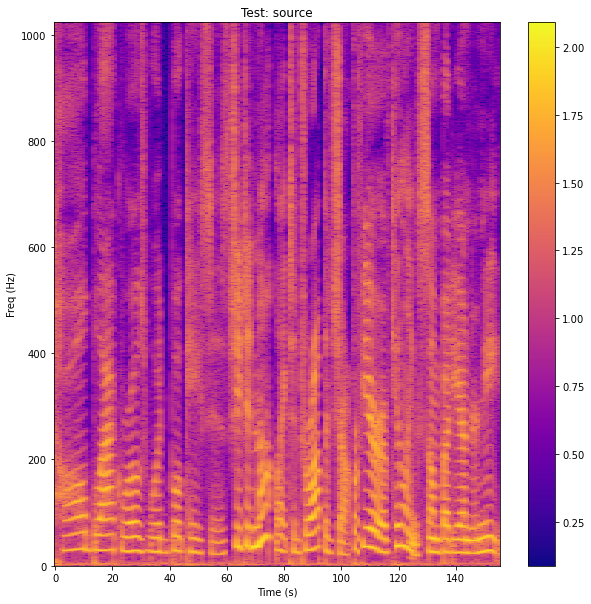

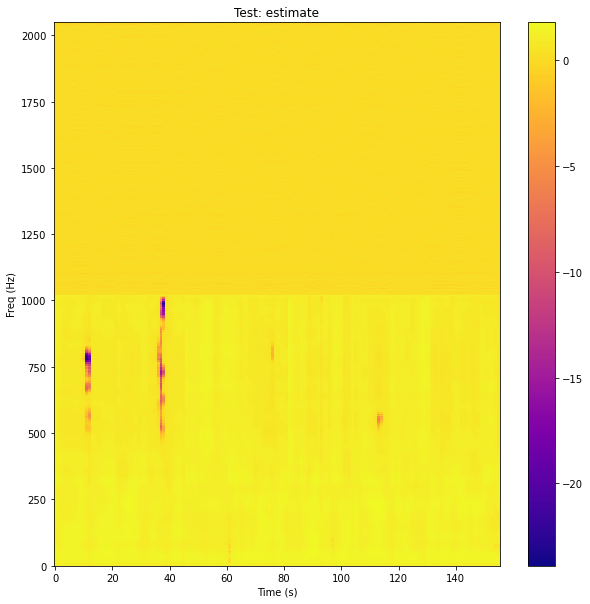

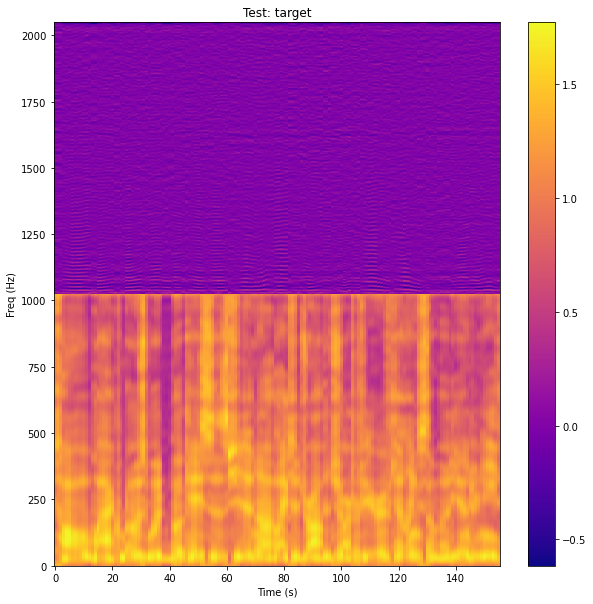

In [81]:
# check which part went wrong in the split model
task_model = pretrained_model
def combine_sample(x, target):
    from env import frame_size
    plot_spec(x[:frame_size], title='Test: source',
              figure_size=(10,10))
    x = torch.from_numpy(x.T).to(device)
    estimated = task_model(x).detach().cpu()
    y = estimated.numpy().T
    plot_spec(y, title='Test: estimate',figure_size=(10,10))

    if target is not None:
        plot_spec(target, title='Test: target',figure_size=(10,10))
    if False:
        sound(griffin_lim(from_gen_model_output(estimated).numpy().T),
              label='Test: estimate')
        if target is not None:
            sound(griffin_lim(from_gen_model_output(target.T).numpy().T),
                  label='Test: target')
    #
    with torch.no_grad():
        recon = estimated.clone()
        recon[:,1025:] = target.T[:,1025:]
        sound(griffin_lim(from_gen_model_output(recon).numpy().T),
              label='Test: recon check lo')
        if target is not None:
            sound(griffin_lim(from_gen_model_output(target.T).numpy().T),
                  label='Test: target')

    with torch.no_grad():
        recon = estimated.clone()
        recon[:,:1025] = target.T[:,:1025]
        sound(griffin_lim(from_gen_model_output(recon).numpy().T),
              label='Test: recon check hi')
        if target is not None:
            sound(griffin_lim(from_gen_model_output(target.T).numpy().T),
                  label='Test: target')


task_test_dat = TaskDataset(meta_data.get(source_speaker_id, test_audio_id),
     meta_data.get(target_speaker_id, test_audio_id))
train_x, train_y = task_test_dat.get()
combine_sample(train_x, torch.from_numpy(train_y))

In [85]:
save_model('saved_models/' + type(model).__name__ + 'from'
        +str(source_speaker_id)+'to'+str(target_speaker_id)+'.pt',
        pretrained_model)

In [82]:
# test with actual samples
